### 2-1. Apply the decision tree for classification using 423-dimension data set.

In [ ]:
# Import libraries

import time
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from os import listdir
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from sklearn.neural_network import MLPClassifier

In [3]:
# This function is used to transform one file's data into a vector

def file2vector(fileName):
    f = open(fileName)
    lines = f.read()
    nums = []
    for i in range(len(lines)):
        if lines[i] == '0' or lines[i] == '1':
            nums.append(lines[i])   
            
    return np.array(list(map(float,nums)))

In [4]:
# This function is used to transform one class's data into a matrix

def files2matrix(path):
    fileList = listdir(path)
    mat = []
    for i in range(len(fileList)):
        vector = file2vector(path + '/' + fileList[i])
        mat.append(vector)
    
    return np.array(mat)

In [5]:
# This function is used to get the whole dataset

def GetDataSet():
    paths = listdir('./data')
    data = []
    for i in range(len(paths)):
        path = './data' +'/' + paths[i]
        data.append(files2matrix(path))

    return np.array(data).reshape(4200,432)

In [6]:
# Load the dataset and set labels
data_X = GetDataSet()
labels = np.array([[i] * int(4200/10) for i in range(10)]).reshape(4200,)
labels_names = np.array(['0','1','2','3','4','5','6','7','8','9'])

In [7]:
# Split the dataset

X_train, X_test, y_train, y_test = train_test_split(data_X, labels, 
                                        test_size=0.3, random_state=0)

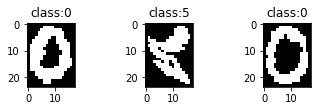

In [8]:
X = X_train.reshape(X_train.shape[0], 24,18)

# data visualization
for i in range(6,9):
    plt.subplot(330+(i+1))
    plt.imshow(X[i], cmap=plt.get_cmap('gray'))
    plt.title("class:" + str(y_train[i]))

In [9]:
# Build a Drecision Tree model

clf_dt = tree.DecisionTreeClassifier(criterion='gini', 
                                     random_state = 0,max_depth=None)

In [10]:
# Train the model

clf_dt = clf_dt.fit(X_train, y_train)

In [11]:
# Export a graph of Decision Tree

import graphviz
dot_data = tree.export_graphviz(clf_dt, out_file=None, 
                            class_names = labels_names,node_ids=True,
                            filled=True, rounded=True,  
                            special_characters=True)
graph = graphviz.Source(dot_data)
graph.render('dt') # save as a pdf file

'dt.pdf'

In [12]:
# Test the model 

# predict on test data
res_dt = clf_dt.predict(X_test) 

# count for error numbers
error_num = 0         

num = len(X_test)           
for i in range(num):         
    if np.sum(res_dt[i] != y_test[i]): 
        error_num += 1                     
print("Total num:",num," Wrong num:", \
      error_num,"  Accuracy:", accuracy_score(y_test, res_dt))

Total num: 1260  Wrong num: 245   Accuracy: 0.8055555555555556


### 2-2. Select the features which appears in the decision tree nodes 

In [13]:
# Get the data of features and labels

f = open('dt')
l = f.readlines()
class_list = []
for i in range(len(l)):
    if "class" in l[i]:
        class_list.append(l[i])

In [17]:
def GetNodeFeature():
    
    feature_list = []
    for i in range(len(class_list)):
        c = class_list[i].split(' = ')[3].split('<br/>')[0].strip('[]').split(',')
        nums=[]
        for s in c :
            nums.append(int(s))
        feature_list.append(nums)
        
    return np.array(feature_list)

In [15]:
feature_list = []
for i in range(len(class_list[10:16])):
    c = class_list[i].split(' = ')[3].split('<br/>')[0].strip('[]').split(',')
    nums=[]
    for s in c :
        nums.append(int(s))
    feature_list.append(nums)
np.array(feature_list).shape

(6, 10)

In [18]:
# Get features from Decision Tree Nodes

features = GetNodeFeature()
features.shape

(731, 10)

In [20]:
def GetNodeLabel():
    node_labels = []
    for i in range(len(class_list)):
        label = int(class_list[i].split('class')[1][3])
        node_labels.append(label)
        
    return np.array(node_labels)

In [21]:
# Get labels from Decision Tree Nodes

node_labels = GetNodeLabel()
node_labels.shape

(731,)

In [22]:
x = features
y = to_categorical(node_labels, num_classes=10)

train_data, test_data, train_label, test_label = train_test_split(x, y,
                                         test_size=0.3, random_state=0)

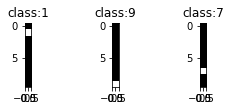

In [23]:
x_new = x.reshape(x.shape[0], 10,1)

# data visualization
for i in range(11,14):
    plt.subplot(330+(i+4))
    plt.imshow(x_new[i], cmap=plt.get_cmap('gray'))
    plt.title("class:" + str(node_labels[i]))

### 2-3. Use the new data set which from 2-2 for classification with MLP

In [32]:
# Build the MLP model

# paremeters
hidden_units = 50
learning_rate = 0.001
train_iter = 2000

clf_mlp = MLPClassifier(hidden_layer_sizes=(hidden_units,),
                    activation='logistic', solver='adam',
                    learning_rate_init = learning_rate, max_iter=train_iter)

In [25]:
t = time.time()

# Train the model 
clf_mlp = clf_mlp.fit(train_data, train_label)

print("It took", time.time() - t, "seconds to train the model.")

It took 3.3678858280181885 seconds to train the model.


In [26]:
# Test the model 

res_mlp = clf_mlp.predict(test_data)   # predict on test data
error_num = 0               # count for error numbers
num = len(test_data)           
for i in range(num):         
    if np.sum(res_mlp[i] == test_label[i]) < 10: 
        error_num += 1                     
print("Total num:",num," Wrong num:", \
      error_num,"  Accuracy:", 1 - error_num/num)

Total num: 220  Wrong num: 8   Accuracy: 0.9636363636363636


In [45]:
# Find the optim learning rate

lrs = np.logspace(-4, 1, 30)
enet = MLPClassifier(hidden_layer_sizes=(hidden_units,),
                    activation='logistic', solver='adam', max_iter=2000)
train_errors = list()
test_errors = list()
for lr in lrs:
    enet.set_params(learning_rate_init=lr)
    enet.fit(train_data, train_label)
    train_errors.append(enet.score(train_data, train_label))
    test_errors.append(enet.score(test_data, test_label))

i_lr_optim = np.argmax(test_errors)
lr_optim = lrs[i_lr_optim]
print("Optimal learning rate : %s" % lr_optim)

D:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
D:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
D:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
D:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
D:\Anaconda3\lib\site-packages\s

Optimal learning rate : 0.0016102620275609393


(0, 1.1)

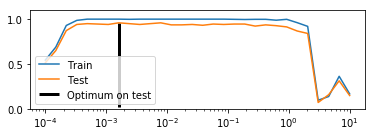

In [47]:
# Plot results for learning rate

import matplotlib.pyplot as plt
plt.subplot(2, 1, 1)
plt.semilogx(lrs, train_errors, label='Train')
plt.semilogx(lrs, test_errors, label='Test')
plt.vlines(lr_optim, plt.ylim()[0], np.max(test_errors), color='k',
           linewidth=3, label='Optimum on test')
plt.legend(loc='lower left')
plt.ylim([0, 1.1])

In [62]:
# Find the optim iteration

iteras = np.random.randint(500, 5000, 30)
enet = MLPClassifier(hidden_layer_sizes=(hidden_units,),learning_rate_init=0.001,
                    activation='logistic', solver='adam')
train_errors = list()
test_errors = list()
for itera in iteras:
    enet.set_params(max_iter=itera)
    enet.fit(train_data, train_label)
    train_errors.append(enet.score(train_data, train_label))
    test_errors.append(enet.score(test_data, test_label))

i_itera_optim = np.argmax(test_errors)
itera_optim = iteras[i_itera_optim]
print("Optimal iterations : %s" % itera_optim)

D:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (665) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
D:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1168) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
D:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1221) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
D:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1462) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
D:\Anaconda3\lib\site-packages\sk

Optimal learning rate : 1398


D:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1297) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


(0, 1.1)

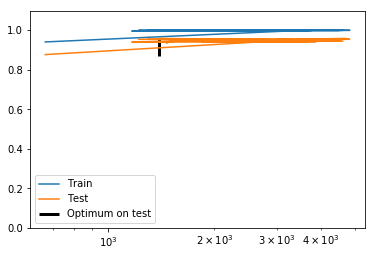

In [65]:
# Plot results for iteration

import matplotlib.pyplot as plt
#plt.subplot(2, 1, 1)
plt.semilogx(iteras, train_errors, label='Train')
plt.semilogx(iteras, test_errors, label='Test')
plt.vlines(itera_optim, plt.ylim()[0], np.max(test_errors), color='k',
           linewidth=3, label='Optimum on test')
plt.legend(loc='lower left')
plt.ylim([0, 1.1])

In [66]:
# Find the optim hidden units

hus = np.random.randint(50, 500, 50)
enet = MLPClassifier(hidden_layer_sizes=(100,),learning_rate_init=0.001,
                    activation='logistic', solver='adam', max_iter=1500)
train_errors = list()
test_errors = list()
for hu in hus:
    enet.set_params(hidden_layer_sizes=(hu,))
    enet.fit(train_data, train_label)
    train_errors.append(enet.score(train_data, train_label))
    test_errors.append(enet.score(test_data, test_label))

i_hu_optim = np.argmax(test_errors)
hu_optim = hus[i_hu_optim]
print("Optimal hidden units : %s" % hu_optim)

Optimal hidden units : 132


(0, 1.1)

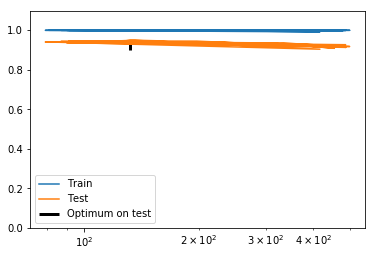

In [68]:
# Plot results for hidden units

import matplotlib.pyplot as plt
#plt.subplot(2, 1, 1)
plt.semilogx(hus, train_errors, label='Train')
plt.semilogx(hus, test_errors, label='Test')
plt.vlines(hu_optim, plt.ylim()[0], np.max(test_errors), color='k',
           linewidth=3, label='Optimum on test')
plt.legend(loc='lower left')
plt.ylim([0, 1.1])